<a href="https://colab.research.google.com/github/crneubert/madrid-airbnb/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

Airbnb is one of the largest housing rental companies worldwide, with millions of users listing and renting properties every day. We found a large Airbnb dataset for the city of Madrid on Kaggle, containing over 7 million listings. The dataset contained calendar.csv, which possessed variables on price, avaliability, nights avaliable, for each calendar day for each property. There also is a listings.csv which contained location, availability, and review data for each indidivual listing.

In investigating the Centro Neighborhood, we recommend Buyers look to purchase in Embajadores, and Renters look to rent in Palacios

### Key Questions




*   How can renters get the best value for their money when renting in Madrid?
*   Where is the best place to purchase properties to list on Airbnb, and how can owners maximize their revenue?




# Problem Decomposition

In order to answer our questions, since they are very similar in nature, we did a broad preliminary analysis to assess the information that we have and how we can build that into answers for our questions, before getting more specific with our actions and questions. Our sub-questions are all listed throughout the report, with interpreted results (to some degree) below the code chunks.

# **SETUP**


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-17-openjdk-amd64/bin"

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import types as sparktypes

# import PySpark aggregate functions with underscores to avoid collision with Python sum, etc
from pyspark.sql.functions import sum as _sum, avg as _avg, count as _count
from pyspark.sql.functions import col, lit, round, month, to_date, when, expr, split, first, broadcast

from pyspark.sql.window import Window
from pyspark.sql.functions import rank, dense_rank, row_number, lag, lead

In [ ]:
!wget -q https://media.githubusercontent.com/media/crneubert/madrid-airbnb/refs/heads/main/data/calendar.csv
!wget -q https://media.githubusercontent.com/media/crneubert/madrid-airbnb/refs/heads/main/data/listings.csv


In [ ]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [ ]:
listings = sqlContext.read.csv("listings.csv", header = True)
calendar = sqlContext.read.csv("calendar.csv", header = True)

# **ANALYSIS**

In [ ]:
listings.show(5)

+-----+--------------------+---------+---------+-------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|   id|                name|  host_id|host_name|neighbourhood_group| neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+-----+--------------------+---------+---------+-------------------+--------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| 6369|Rooftop terrace r...|    13660|    Simon|          Chamartín|Hispanoamérica|40.45724| -3.67688|   Private room|   60|             1|               78| 2020-09-20|             0.58|                             1|             180|
|21853|Bright and airy room|    83531|    Abdel|        

In [ ]:
calendar.show(5)

+----------+----------+---------+------+--------------+--------------+--------------+
|listing_id|      date|available| price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+------+--------------+--------------+--------------+
|    167183|2021-04-15|        f|$45.00|        $45.00|             1|             5|
|      6369|2021-04-15|        t|$60.00|        $60.00|             1|          1125|
|      6369|2021-04-16|        t|$60.00|        $60.00|             1|          1125|
|      6369|2021-04-17|        t|$60.00|        $60.00|             1|          1125|
|      6369|2021-04-18|        t|$60.00|        $60.00|             1|          1125|
+----------+----------+---------+------+--------------+--------------+--------------+
only showing top 5 rows



**Cleaning Datasets**

In [ ]:
listings_clean = (listings.withColumnRenamed("id", "listing_id")
                         .filter(col("room_type").isin("Shared room", "Private room", "Entire home/apt", "Hotel room")))
#Filtered to have Room Types that are not integers or unusual values



calendar_clean = (calendar.withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                          .groupBy("listing_id")
                          .agg(_avg("available_boolean").alias("occupancy_rate")))

#Added occupancy rate to calendar df

combo_pizza = (listings_clean.join(calendar_clean, on="listing_id")
                             .withColumn("number_of_reviews", col("number_of_reviews").cast("int"))
                             .withColumn("minimum_nights", col("minimum_nights").cast("int"))
                             .withColumn("price", col("price").cast("int"))
                             .withColumn("reviews_per_month", col("reviews_per_month").cast("int")))

#Type cast variables (that were for some reason non-integer)


**Room Type**

In [ ]:
room_type = (combo_pizza.groupBy("room_type")
                        .agg(round(_avg("occupancy_rate"), 2).alias("avg_occupancy_rate"))
                        .orderBy("avg_occupancy_rate", ascending = False))
room_type.show()

+---------------+------------------+
|      room_type|avg_occupancy_rate|
+---------------+------------------+
|   Private room|              0.56|
|Entire home/apt|              0.53|
|    Shared room|              0.51|
|     Hotel room|              0.35|
+---------------+------------------+



Found the average occupancy rate by room type. It appears that Private rooms and entire homes/apartments have the highest occupancy. This is likely due to renters valuing privacy and seclusion.

Hotel rooms unsurprisingly have high vacancy, as hotels are likely very available and not frequently rented on AirBnB.

**What time is best to have AirBnb available to rent?**

In [ ]:
best_time = (calendar.withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1)) # integerized availability
                     .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                     .withColumn("month", month(col("date"))) # date/month columns
                     .groupBy("month")
                     .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                     .orderBy("month_occ_rate", ascending = False)
)
best_time.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    4|          0.61|
|    3|           0.6|
|    2|           0.6|
|    1|          0.59|
|   12|          0.58|
|   11|          0.58|
|   10|          0.54|
|    5|           0.5|
|    9|          0.48|
|    8|          0.48|
|    7|          0.45|
|    6|          0.44|
+-----+--------------+



We found that occupancy rate is the highest from in April, and the pattern continues 'backwards' through the year, with May having a surge above the beginning of the summer months, potentially because some April stays bled into May. We assume this pattern is the case because people prefer to be closer to the sea in the summer months, because Madrid is inland and not next to a beach.

**Is there a correlation between Occupancy Rate and Listing Prices?**

In [ ]:
print(combo_pizza.corr("occupancy_rate", "price"))


0.016470467622479442


Next we looked at correlation between occupancy rate and price, which we assumed would have a positive correlation because when properties are in more demand, the suppliers can up the prices. However, we found no correlation.

**Lets take a look at Occupancy Rates in each Neighborhood**

In [ ]:
neighborhood = (combo_pizza.groupBy("neighbourhood")
                           .agg(round(_avg("occupancy_rate"), 2).alias("avg_occupancy_rate"),
                                _count("*").alias("listing_per_neighborhood"))
                           .orderBy("listing_per_neighborhood", ascending = False)
                           .filter(col("listing_per_neighborhood") > 200))
neighborhood.show()

+----------------+------------------+------------------------+
|   neighbourhood|avg_occupancy_rate|listing_per_neighborhood|
+----------------+------------------+------------------------+
|     Embajadores|              0.57|                    2311|
|     Universidad|              0.53|                    1867|
|         Palacio|              0.54|                    1499|
|             Sol|              0.52|                    1120|
|        Justicia|              0.53|                     948|
|          Cortes|              0.48|                     880|
|       Trafalgar|              0.53|                     370|
| Palos de Moguer|              0.57|                     337|
|            Goya|              0.56|                     296|
|       Argüelles|              0.58|                     280|
|       Recoletos|              0.54|                     274|
|Puerta del Angel|              0.57|                     271|
|      Guindalera|              0.54|                  

**Now lets see how occupancy rates look across each neighborhood group, since there are so many neighborhoods to look at**

In [ ]:
neighborhood_group = (combo_pizza.groupBy("neighbourhood_group")
                           .agg(round(_avg("occupancy_rate"), 2).alias("avg_occupancy_rate"),
                                _count("*").alias("listing_per_group"))
                           .orderBy("listing_per_group", ascending = False)
                           .filter(col("listing_per_group") > 100))
neighborhood_group.show()

+--------------------+------------------+-----------------+
| neighbourhood_group|avg_occupancy_rate|listing_per_group|
+--------------------+------------------+-----------------+
|              Centro|              0.54|             8625|
|           Salamanca|              0.55|             1324|
|            Chamberí|              0.54|             1248|
|          Arganzuela|              0.61|             1102|
|              Tetuán|              0.54|              810|
|         Carabanchel|               0.5|              707|
|              Retiro|              0.55|              662|
|       Ciudad Lineal|              0.55|              649|
|  Puente de Vallecas|              0.44|              614|
|              Latina|              0.55|              605|
|           Chamartín|              0.52|              577|
|   Moncloa - Aravaca|              0.55|              553|
|San Blas - Canill...|              0.48|              490|
|           Hortaleza|              0.52

It appears that Centro dominates the other neighborhood groups in terms of sheer listing count, so it would be worthwhile to dive deeper into Centro data, because we can feel more confident about our conclusions given the large sample size.

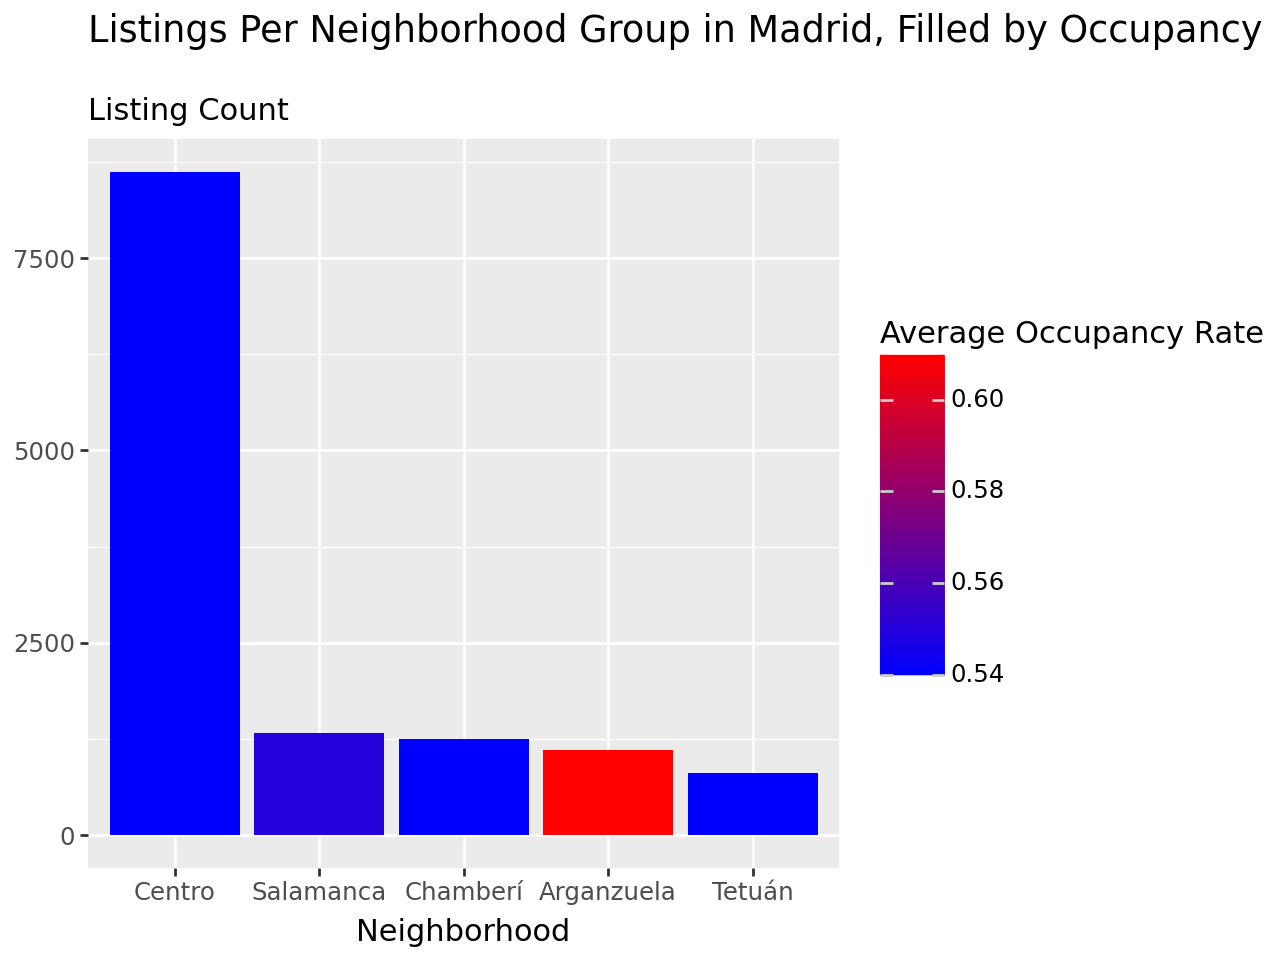

In [ ]:
from plotnine import ggplot, aes, labs, scale_fill_gradient, geom_point, geom_line, geom_bar, geom_col, geom_histogram

import pandas as pd

neighborhood_group_pd = neighborhood_group.toPandas()

neighborhood_group_pd = neighborhood_group_pd.sort_values("listing_per_group", ascending=True)

top5 = (
    neighborhood_group_pd
        .sort_values("listing_per_group", ascending=False)
        .head(5)
)

# Reorder categories based on sorted values
top5["neighbourhood_group"] = pd.Categorical(
    top5["neighbourhood_group"],
    categories = top5["neighbourhood_group"],
    ordered = True
)

listing_plot = (ggplot(top5, mapping = aes(x = "neighbourhood_group", y = "listing_per_group", fill = "avg_occupancy_rate")) +
                      geom_col() +
                      labs(x = "Neighborhood",
                           y = "",
                           subtitle = "Listing Count",
                           title = "Listings Per Neighborhood Group in Madrid, Filled by Occupancy \n",
                           fill = "Average Occupancy Rate") +
                      scale_fill_gradient(low = "blue", high = "red")
                      )

listing_plot

#Carson did this


**Let's look at the Average Price per Neighborhood in Centro, as well as the listing count to ensure that we have a large enough sample size.**

In [ ]:
centro = (combo_pizza.filter(col("neighbourhood_group") == "Centro")
                     .groupBy("neighbourhood")
                     .agg(round(_avg("price"), 2).alias("Average Price Per Neighborhood"),
                          _count("*").alias("Listings Per Neighborhood"))
)
centro.show()


+-------------+------------------------------+-------------------------+
|neighbourhood|Average Price Per Neighborhood|Listings Per Neighborhood|
+-------------+------------------------------+-------------------------+
|  Universidad|                        108.45|                     1867|
|          Sol|                         128.2|                     1120|
|      Palacio|                        101.17|                     1499|
|     Justicia|                        108.44|                      948|
|       Cortes|                        196.07|                      880|
|  Embajadores|                        139.53|                     2311|
+-------------+------------------------------+-------------------------+



We will come back to this data later.

**We found the Spanish Zillow (Idealista) has data by neighborhood on square footage, bed and bath count, and price of sale in Madrid, so we wanted to look at price fairness for both renters and buyers**

In [ ]:
import glob
import kagglehub

local_dir = kagglehub.dataset_download("kanchana1990/madrid-idealista-property-listings")
csv_path = os.path.join(local_dir, "idealista_madrid.csv")

centro_more = (spark.read.format("csv")
      .option("header", "true")
      .option("inferSchema", "true")
      .csv(csv_path))

Using Colab cache for faster access to the 'madrid-idealista-property-listings' dataset.


# Performance Tuning (broadcasting)

In [ ]:
centro_clean = (centro_more.withColumn("address", split(col("address"), ",")[0]))
#Idealista had a column "address" that was of the format Neighborhood, Madrid which we only wanted the neighborhood from


centro_total = (centro.join(broadcast(centro_clean), centro_clean["address"].contains(centro["neighbourhood"]), "inner") # make broadcast explicit
                      .drop("address"))

#centro_total.show()
centro_total.explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [neighbourhood#6428, Average Price Per Neighborhood#7240, Listings Per Neighborhood#7242L, url#7294, listingUrl#7295, title#7296, id#7297, price#7298, baths#7299, rooms#7300, sqft#7301, description#7302, typology#7304, advertiserProfessionalName#7305, advertiserName#7306]
   +- BroadcastNestedLoopJoin BuildRight, Inner, Contains(address#7320, neighbourhood#6428)
      :- HashAggregate(keys=[neighbourhood#6428], functions=[avg(price#6696), count(1)])
      :  +- Exchange hashpartitioning(neighbourhood#6428, 200), ENSURE_REQUIREMENTS, [plan_id=13208]
      :     +- HashAggregate(keys=[neighbourhood#6428], functions=[partial_avg(price#6696), partial_count(1)])
      :        +- Project [neighbourhood#6428, cast(price#6432 as int) AS price#6696]
      :           +- BroadcastHashJoin [listing_id#6605], [listing_id#6472], Inner, BuildLeft, false
      :              :- BroadcastExchange HashedRelationBroadcastMode(List(input

Here we join the local Centro dataset with the much smaller Idealista dataset. Due to the difference in size of these datasets, specifically the Idealista one being small, we decided to broadcast the Idealista dataset onto the larger Centro one. Doing this, we save runtime, because the Idealista dataset is in memory as the join is happening (map-side join).

In [ ]:
overall_avg = centro_total.agg(
    round(_avg("Average Price Per Neighborhood"), 2).alias("Overall Centro Average")
)

centro_discovery = (centro_total.withColumn("Price Per Square Foot", round(col("price") / col("sqft"), 2))
                                .groupBy("neighbourhood")
                                .agg(round(_avg("Price Per Square Foot"), 2).alias("Price Per Square Foot"),
                                     first("Average Price Per Neighborhood").alias("Average Listing Price"))
                                .crossJoin(overall_avg)
                                .withColumn("Value Score (for the renter)", round(col("Price Per Square Foot") / col("Average Listing Price"), 2))
                                .orderBy("Value Score (for the renter)", ascending = False))
centro_discovery.show()
#centro_discovery.explain()


+-------------+---------------------+---------------------+----------------------+----------------------------+
|neighbourhood|Price Per Square Foot|Average Listing Price|Overall Centro Average|Value Score (for the renter)|
+-------------+---------------------+---------------------+----------------------+----------------------------+
|      Palacio|              8034.43|               101.17|                123.57|                       79.42|
|     Justicia|              8370.16|               108.44|                123.57|                       77.19|
|          Sol|              7749.63|                128.2|                123.57|                       60.45|
|  Universidad|              6515.19|               108.45|                123.57|                       60.08|
|       Cortes|              7123.18|               196.07|                123.57|                       36.33|
|  Embajadores|              4700.23|               139.53|                123.57|                      

First, we calculated the average price per square foot within each neighborhood of Centro, in order to gauge how expensive each neighborhood is in general. Then, we found the average listing price for each neighborhood to understand how much an airBnB would cost per night generally. We have listed the average of the whole Centro group to compare with as well. Using both  the average price per square foot and average listing price, we then calculate a Value Score, where a higher number means better value for the renter, and a lower score means better value for a buyer looking to buy a property for the purpose of renting through AirBnB. It is important to notice that the Value Score can exceed 100, it is not standardized.

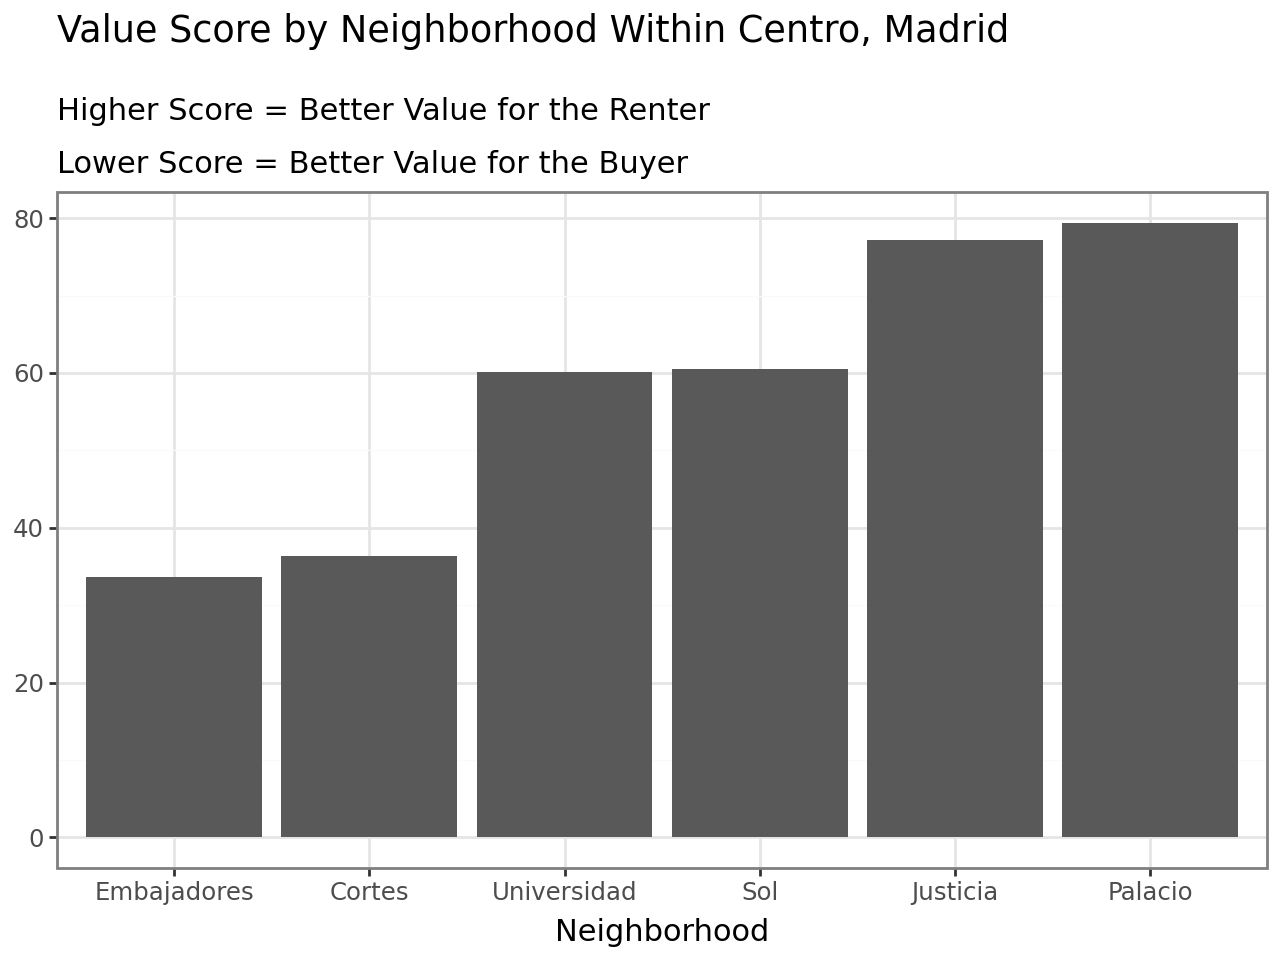

In [ ]:
from plotnine import ggplot, aes, labs, theme_bw, scale_fill_gradient, geom_point, geom_line, geom_bar, geom_col, geom_histogram
import pandas as pd

centro_discovery_pd = centro_discovery.toPandas()

centro_discovery_pd = centro_discovery_pd.sort_values("Value Score (for the renter)", ascending=True)

#Reorder neighborhoods by Value Score
centro_discovery_pd["neighbourhood"] = pd.Categorical(
    centro_discovery_pd["neighbourhood"],
    categories = centro_discovery_pd["neighbourhood"],
    ordered=True
)

value_plot = (ggplot(centro_discovery_pd, aes(x = "neighbourhood", y = "Value Score (for the renter)")) +
              geom_col() +
              labs(x = "Neighborhood",
                   y = "",
                   title = "Value Score by Neighborhood Within Centro, Madrid \n",
                   subtitle = "Higher Score = Better Value for the Renter \n \nLower Score = Better Value for the Buyer") +
              theme_bw()
              )

value_plot

#Otis did this

**Below is just proof that each neighborhood has a 'decent enough' occupancy rate so that it is worth renting in**

In [ ]:
best_time_palacio = (calendar.join(listings_clean, on = "listing_id")
                             .filter(col("neighbourhood") == "Palacio")
                             .withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                             .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                             .withColumn("month", month(col("date")))
                             .groupBy("month")
                             .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                             .orderBy("month_occ_rate", ascending = True)

)
best_time_palacio.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    6|          0.44|
|    7|          0.45|
|    8|          0.46|
|    9|          0.47|
|    5|          0.52|
|   10|          0.54|
|   12|          0.58|
|   11|          0.58|
|    1|          0.61|
|    3|          0.63|
|    4|          0.63|
|    2|          0.63|
+-----+--------------+



In [ ]:
best_time_embajadores = (calendar.join(listings_clean, on = "listing_id")
                             .filter(col("neighbourhood") == "Embajadores")
                             .withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                             .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                             .withColumn("month", month(col("date")))
                             .groupBy("month")
                             .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                             .orderBy("month_occ_rate", ascending = False)

)
best_time_embajadores.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    4|          0.65|
|   12|          0.61|
|    1|          0.61|
|    3|          0.61|
|   11|          0.61|
|    2|          0.61|
|   10|          0.57|
|    5|          0.56|
|    9|          0.52|
|    8|          0.51|
|    6|           0.5|
|    7|           0.5|
+-----+--------------+



In [ ]:
best_time_justicia = (calendar.join(listings_clean, on = "listing_id")
                             .filter(col("neighbourhood") == "Justicia")
                             .withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                             .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                             .withColumn("month", month(col("date")))
                             .groupBy("month")
                             .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                             .orderBy("month_occ_rate", ascending = False)

)
best_time_justicia.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    4|          0.62|
|    3|          0.57|
|    2|          0.57|
|   12|          0.56|
|   11|          0.56|
|    1|          0.54|
|    5|          0.53|
|   10|          0.53|
|    9|           0.5|
|    8|          0.48|
|    7|          0.47|
|    6|          0.45|
+-----+--------------+



In [ ]:
best_time_sol = (calendar.join(listings_clean, on = "listing_id")
                             .filter(col("neighbourhood") == "Sol")
                             .withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                             .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                             .withColumn("month", month(col("date")))
                             .groupBy("month")
                             .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                             .orderBy("month_occ_rate", ascending = False)

)
best_time_sol.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    4|          0.61|
|    2|           0.6|
|    3|          0.59|
|    1|          0.58|
|   12|          0.54|
|   11|          0.54|
|   10|          0.53|
|    5|          0.48|
|    9|          0.48|
|    8|          0.47|
|    7|          0.45|
|    6|          0.43|
+-----+--------------+



In [ ]:
best_time_universidad = (calendar.join(listings_clean, on = "listing_id")
                             .filter(col("neighbourhood") == "Universidad")
                             .withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                             .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                             .withColumn("month", month(col("date")))
                             .groupBy("month")
                             .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                             .orderBy("month_occ_rate", ascending = False)

)
best_time_universidad.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    4|          0.61|
|    3|          0.58|
|    2|          0.58|
|   12|          0.57|
|    1|          0.57|
|   11|          0.56|
|   10|          0.54|
|    5|          0.51|
|    9|           0.5|
|    8|          0.48|
|    6|          0.46|
|    7|          0.45|
+-----+--------------+



In [ ]:
best_time_cortes = (calendar.join(listings_clean, on = "listing_id")
                             .filter(col("neighbourhood") == "Cortes")
                             .withColumn("available_boolean", when(col("available") == "t", 0).otherwise(1))
                             .withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
                             .withColumn("month", month(col("date")))
                             .groupBy("month")
                             .agg(round(_avg("available_boolean"),2).alias("month_occ_rate")) #occupancy rate monthwise
                             .orderBy("month_occ_rate", ascending = False)

)
best_time_cortes.show()

+-----+--------------+
|month|month_occ_rate|
+-----+--------------+
|    4|           0.6|
|    5|          0.53|
|    3|          0.52|
|    2|          0.52|
|    1|           0.5|
|   12|          0.48|
|   11|          0.47|
|   10|          0.44|
|    6|          0.43|
|    7|          0.42|
|    9|          0.41|
|    8|          0.41|
+-----+--------------+



# **CONCLUSION**

For Airbnb owners (in Madrid) generally, properties with private rooms or the entire estate available result in the highest occupancy rate. Also, October-April are the months with the highest occupancy rates, meaning Airbnb owners should ensure their properties are avaliable at those times.

So, for renters, the best place to rent in Madrid is Palacio. The high Value Score indicates the neighborhood has more square footage, more expensive homes, which are being listed for lower prices on average. Thus, renters in Palacio are getting the best Airbnb for the lowest price. Renters should also look to rent in the Summer, as there will be the most available Airbnbs at that time.

For prospective buyers, the best place to purchase a property to list on Airbnb is Embajadores - by far. The low Value Score indicates this neighborhood has cheaper homes, which are listed for more on average, meaning Embajadores Airbnbs have a low entry cost and a high return. Buyers should also ensure they are keeping their properties available from October to April as this season has the highest occupancy rate.

PySpark was extremely effective for a large-scale distributed computing problem such as our AirBnB problem. The dataset was from one year, 2021, and one city, so if AirBnB were to do their own analyses, they would have every city across the globe, and multiple years to deal with, which would be incredibly large amounts of data that a distributed computing workflow would be the best to work with.

We think our approach was solid, in that we had a defined scope which we followed and we were able to reach a relevant conclusion. However, we wished we were able to perform analysis on other years as well, to see the effects over time.

In the future in this project, we would have loved to have unabridged access to all of AirBnB's data, and do something more predictive so that we could more readily recommend certain actions for buyers and renters, because the past does not predict the future, and our analysis does not account for error in prediction.



